In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

## Sparsity

#### Threshold - Percentage

Currently missing Baseline Values

##### Load Data

In [68]:
# Load and visualize sparsity threshold results
df_threshold = pd.read_csv('sparsity_threshold_results.csv')

print("Data loaded:")
print(df_threshold)
print(f"\nShape: {df_threshold.shape}")
print(f"Methods: {df_threshold['method'].unique()}")
print(f"Thresholds: {df_threshold['threshold'].unique()}")

# Calculate confidence bounds
df_threshold['mean_lower'] = df_threshold['mean'] - df_threshold['std']
df_threshold['mean_upper'] = df_threshold['mean'] + df_threshold['std']

# Create numeric x-axis for thresholds
threshold_order = sorted(df_threshold['threshold'].unique())
df_threshold['threshold_numeric'] = df_threshold['threshold'].apply(lambda x: threshold_order.index(x))


Data loaded:
    threshold method   mean   std
0      0.0200     bw  58.43  7.25
1      0.0200     sc  55.62  6.89
2      0.0200     co  81.51  4.05
3      0.0100     bw  37.10  5.95
4      0.0100     sc  33.64  5.13
5      0.0100     co  66.02  5.03
6      0.0075     bw  29.37  5.00
7      0.0075     sc  26.31  4.21
8      0.0075     co  57.38  5.05
9      0.0050     bw  20.61  3.76
10     0.0050     sc  18.33  3.18
11     0.0050     co  44.20  4.51

Shape: (12, 4)
Methods: ['bw' 'sc' 'co']
Thresholds: [0.02   0.01   0.0075 0.005 ]


##### Plot

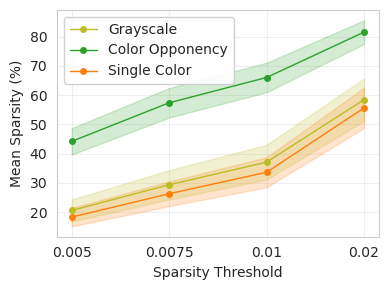


Visualization complete!


In [76]:

# Create the lineplot with error bands
fig, ax = plt.subplots(figsize=(4, 3))

# Plot lines and markers for each method
colors = {'bw': '#bcbd22', 'sc': '#ff7f0e', 'co': '#2ca02c'}
method_labels = {'bw': 'Grayscale', 'sc': 'Single Color', 'co': 'Color Opponency'}

for method in sorted(df_threshold['method'].unique()):
    data_subset = df_threshold[df_threshold['method'] == method].sort_values('threshold_numeric')
    
    # Plot main line
    ax.plot(data_subset['threshold_numeric'], data_subset['mean'], 
            marker='o', label=method_labels[method], linewidth=1, markersize=4,
            color=colors[method])
    
    # Add error bands
    ax.fill_between(data_subset['threshold_numeric'], 
                    data_subset['mean_lower'], 
                    data_subset['mean_upper'], 
                    alpha=0.2, color=colors[method])

# Customize the plot
ax.set_xlabel('Sparsity Threshold', fontsize=10)
ax.set_ylabel('Mean Sparsity (%)', fontsize=10)
#ax.set_title('Sparsity Percentages Across Sparsity Thresholds for Cityscapes Images\n(Error Bands show ± Standard Deviation)', 
 #            fontsize=12, pad=5)

# Set x-axis labels
ax.set_xticks(range(len(threshold_order)))
ax.set_xticklabels([f'{t}' for t in threshold_order], rotation=0)

ax.legend(fontsize=10, loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Save the figure as PDF
fig.savefig("../Figure-PDFs/Sparsity_Thresholds.pdf", bbox_inches='tight')


print("\nVisualization complete!")

#### Sparcity Percentage - mIoU

##### Load Data

In [56]:

# Load three CSV files
df1 = pd.read_csv('Sparsity_Cityscapes_perc.csv') 
df2 = pd.read_csv('Sparsity_Cityscapes_Dark_Zurich_perc.csv') 
df3 = pd.read_csv('Sparsity_Cityscapes_ACDC_perc.csv') 
df4 = pd.read_csv('metrics_averaged_over_seed (1).csv')
df5 = pd.read_csv('val.csv')

# Define sparsity order for consistent x-axis
sparsity_order_perc = ['0', '40', '50', '60', '70', '80', '90']

# Function to process and filter data
def process_dataframe(df, architecture_filter=None):
    # Filter data - remove the baseline row with no preprocessing for clearer visualization
    df_filtered = df[df['Preprocessing'] != '-'].copy()
    
    # If architecture filter is provided, apply it
    if architecture_filter is not None:
        df_filtered = df_filtered[df_filtered['Architecture'] == architecture_filter]
    
    # Create a combined sparsity label for better readability
    df_filtered['Sparsity_Label'] = df_filtered['Sparsity'].fillna('0%')
    df_filtered['Sparsity_Label'] = df_filtered['Sparsity_Label'].replace('-', '0')
    
    # Remove percent_ from sparsity labels for cleaner display
    df_filtered['Sparsity_Label'] = df_filtered['Sparsity_Label'].str.replace('percent_', '')
    df_filtered['Sparsity_Label'] = df_filtered['Sparsity_Label'].str.replace('%', '')
    
    # Calculate confidence bounds for error bands
    df_filtered['mIoU_lower'] = df_filtered['mIoU'] - df_filtered['mIoU_var']
    df_filtered['mIoU_upper'] = df_filtered['mIoU'] + df_filtered['mIoU_var']
    
    # Create a numeric index for sparsity levels for x-axis
    df_filtered['sparsity_numeric'] = df_filtered['Sparsity_Label'].apply(
        lambda x: sparsity_order_perc.index(x) if x in sparsity_order_perc else -1
    )
    
    return df_filtered

# Apply processing to all three dataframes
df1_filtered = process_dataframe(df1)
df2_filtered = process_dataframe(df2)
df3_filtered = process_dataframe(df3)
df4_filtered = process_dataframe(df4)
df5_filtered = process_dataframe(df5, architecture_filter='mask2former')  # Filter for Mask2Former architecture in df5

##### Create Plot

In [57]:
# Use custom colors for each preprocessing method
colors = {'baseline': '#1f77b4', 'grayscale': '#bcbd22', 'single-color': '#ff7f0e', 'color-opponency': '#2ca02c'}

# Function to plot data on a given axis
def plot_data(ax, df_filtered, dataset_title):
    # Plot lines and markers for each preprocessing method
    for preprocessing in df_filtered['Preprocessing'].unique():
        data_subset = df_filtered[df_filtered['Preprocessing'] == preprocessing].sort_values('sparsity_numeric')
        
        # Plot first segment (between first and second x-values) with dotted line
        if len(data_subset) >= 2:
            first_two = data_subset.iloc[:2]
            ax.plot(first_two['sparsity_numeric'], first_two['mIoU'], 
                    marker='o', linewidth=1, markersize=4, color=colors[preprocessing], 
                    linestyle=':')
        
        # Plot remaining segments with solid line (without label to avoid duplication)
        if len(data_subset) > 2:
            ax.plot(data_subset['sparsity_numeric'].iloc[1:], data_subset['mIoU'].iloc[1:], 
                    marker='o', linewidth=1, markersize=4, color=colors[preprocessing], 
                    linestyle='-', label=preprocessing)
        
        # Add error bands
        ax.fill_between(data_subset['sparsity_numeric'], 
                        data_subset['mIoU_lower'], 
                        data_subset['mIoU_upper'], 
                        alpha=0.15, color=colors[preprocessing])
    
    # Customize the plot
    ax.set_title(f'{dataset_title}', 
                 fontsize=10,pad=5)
    
    # Set x-axis labels
    x_labels = {i: label for i, label in enumerate(sparsity_order_perc)}
    ax.set_xticks(range(len(sparsity_order_perc)))
    ax.set_xticklabels([x_labels[i] for i in range(len(sparsity_order_perc))])
    
    ax.legend(fontsize=10, loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3)


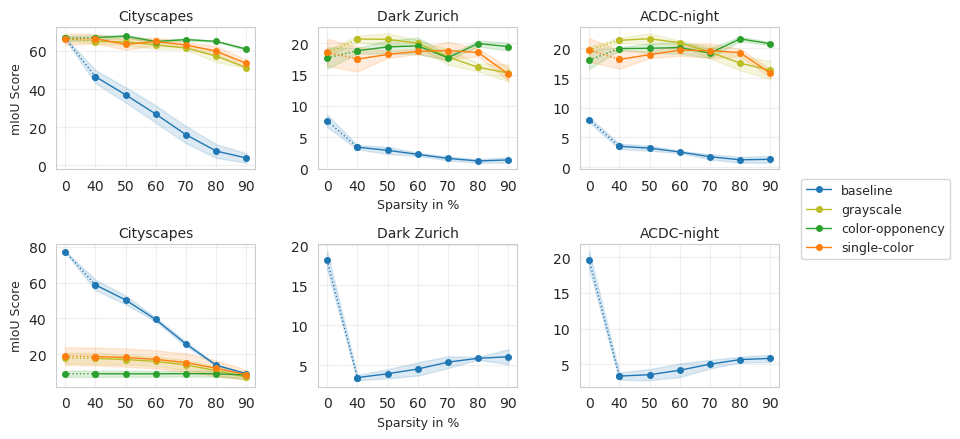

Visualization complete!


In [58]:
# Create the lineplot with error bands - side by side comparison

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(8, 4.5))


# Plot all three datasets
plot_data(ax1, df1_filtered, 'Cityscapes')
plot_data(ax2, df2_filtered, 'Dark Zurich') 
plot_data(ax3, df3_filtered, 'ACDC-night')

plot_data(ax4, df5_filtered[df5_filtered['Dataset'] == 'cityscapes'], 'Cityscapes')
plot_data(ax5, df5_filtered[df5_filtered['Dataset'] == 'dark_zurich'], 'Dark Zurich')
plot_data(ax6, df5_filtered[df5_filtered['Dataset'] == 'acdc_night'], 'ACDC-night')


# Set y-label only for the leftmost plot
ax1.set_ylabel('mIoU Score', fontsize=9)
ax2.set_ylabel(' ')
ax3.set_ylabel(' ')
ax4.set_ylabel('mIoU Score', fontsize=9)
ax5.set_ylabel(' ')
ax6.set_ylabel(' ')

# Set x-label for center plot
ax1.set_xlabel('')
ax2.set_xlabel('Sparsity in %', fontsize=9)
ax3.set_xlabel('')
ax4.set_xlabel('')
ax5.set_xlabel('Sparsity in %', fontsize=9)
ax6.set_xlabel('')

# Collect legend handles and labels from all axes and deduplicate
handles = []
labels = []
for ax in (ax1, ax2, ax3, ax4, ax5, ax6):
    h, l = ax.get_legend_handles_labels()
    for hi, li in zip(h, l):
        if li not in labels:
            handles.append(hi)
            labels.append(li)
    # remove individual axis legends if present
    lg = ax.get_legend()
    if lg is not None:
        lg.remove()

# Place a single legend to the right of the subplots
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=9)

# Adjust layout to make room for the legend
plt.tight_layout()
plt.show()

# Save figure to PDF file
fig.savefig("../Figure-PDFs/DeepLab-Mask2Former_Sparsity_mIoU.pdf", bbox_inches='tight')

print("Visualization complete!")

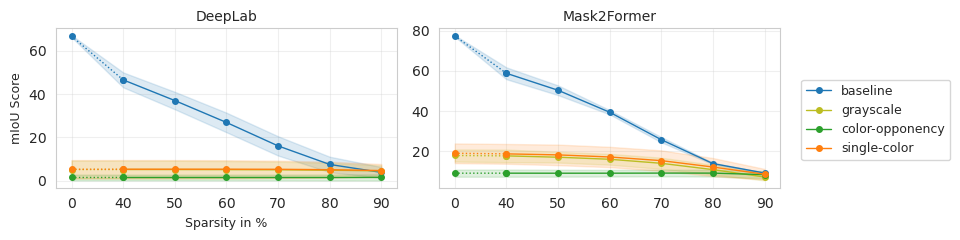

In [55]:
# Create Plot from df4 (metrics averaged over seeds)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 2.5))

plot_data(ax1, df4_filtered[df4_filtered['Architecture'] == 'deeplabv3plus'], 'DeepLab')
plot_data(ax2, df4_filtered[df4_filtered['Architecture'] == 'mask2former'], 'Mask2Former')
# Set y-label and x-label
ax1.set_ylabel('mIoU Score', fontsize=9)
ax1.set_xlabel('Sparsity in %', fontsize=9)

# Remove individual axis legend if present
lg = ax1.get_legend()
if lg is not None:
    lg.remove()

lg = ax2.get_legend()
if lg is not None:
    lg.remove()

# Place legend to the right of the plot
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=9)

# Adjust layout to make room for the legend
plt.tight_layout()
plt.show()

# Save figure to PDF file
fig.savefig("../Figure-PDFs/Zero-shot_Cityscapes_DeepLab_Mask2Former_Sparsity_mIoU.pdf", bbox_inches='tight')